# EPO IPC investigation 

In [1]:
# Adjusting screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#### Relevant imports

In [2]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm
import pandas as pd
import matplotlib as mpl
from itertools import count
import geopandas as gpd
import pydot
from networkx.drawing.nx_pydot import to_pydot
import igraph as ig
import matplotlib.pyplot as plt

%matplotlib inline

#### Relevant data

In [417]:
IPC_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_all_IPC_2.csv')
IPC_raw['ipc_class_symbol'] = IPC_raw['ipc_class_symbol'].astype(str).str[:3] # Shorten IPC to level n precision

In [418]:
Patent_info_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_Patents_cited_wIPC.csv')[['app_nbr','appln_id','reg_code','prio_year','IPC']].drop_duplicates()

In [419]:
IPC_Patent_MERGE = IPC_raw.merge(Patent_info_raw, left_on='Citing_appln_id', right_on='appln_id') # Associating known IPCs to their specific patents
IPC_Patent_MERGE = IPC_Patent_MERGE[['app_nbr','reg_code','prio_year','ipc_class_symbol']]

In [420]:
Citations_raw = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_citations.csv')

In [421]:
IPC_Citations_MERGE = Citations_raw.merge(IPC_Patent_MERGE, left_on='source', right_on='app_nbr').drop(columns='app_nbr') # Associating known IPCs to their specific patents
IPC_Citations_MERGE = IPC_Citations_MERGE.rename(columns={'reg_code':'source_reg_code','prio_year':'source_prio_year','ipc_class_symbol':'source_ipc'})
IPC_Citations_MERGE = IPC_Citations_MERGE.merge(IPC_Patent_MERGE, left_on='target', right_on='app_nbr') # Associating known IPCs to their specific patents
IPC_Citations_MERGE = IPC_Citations_MERGE.rename(columns={'reg_code':'target_reg_code','prio_year':'target_prio_year','ipc_class_symbol':'target_ipc'})
IPC_CLASSES = list(set(np.array(IPC_Citations_MERGE[['source_ipc','target_ipc']]).flatten()))

In [422]:
edges = IPC_Citations_MERGE.drop_duplicates()[['source_ipc','target_ipc']].astype(str)
count_occ = edges.groupby(['source_ipc','target_ipc']).size()
count_frame = pd.DataFrame(list(dict(count_occ.items()).keys()), columns=[['source','target']])
count_frame['count'] = dict(count_occ).values()

In [423]:
edge = list(zip(list(np.array(count_frame['source']).flatten()),list(np.array(count_frame['target']).flatten())))

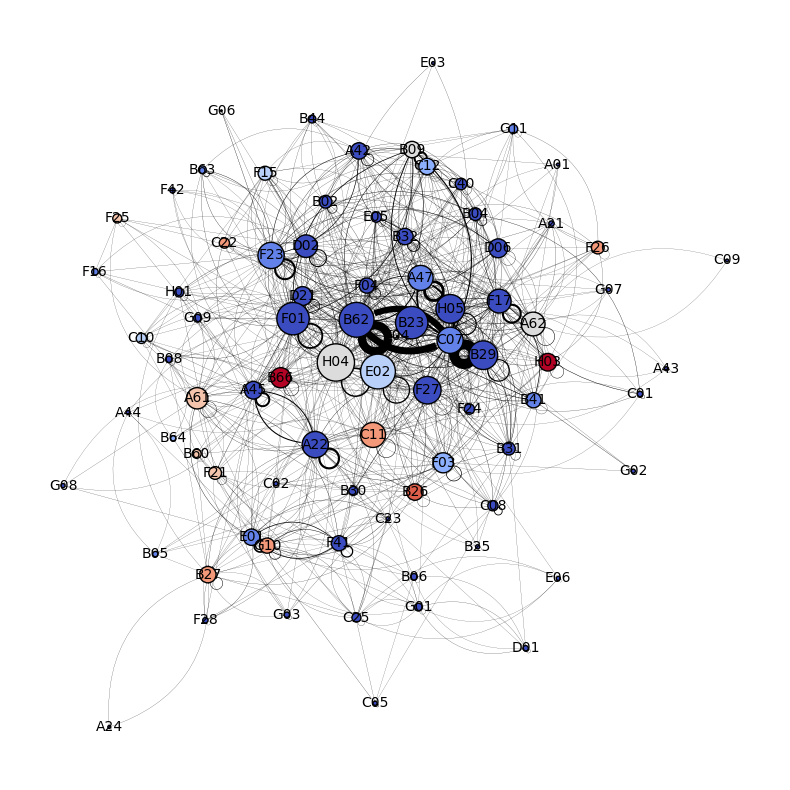

In [460]:
g = ig.Graph(directed=True)
g.add_vertices(IPC_CLASSES)
g.add_edges(edge)
g.es['weight'] = list(np.array(count_frame['count']).flatten())
largest = g.connected_components().giant()
communities = largest.community_edge_betweenness()
communities = communities.as_clustering()
fig, ax = plt.subplots(figsize=(2, 2))
in_degrees = largest.degree(mode='in')
out_degrees = largest.degree(mode='out')
degrees = list(np.array(in_degrees)-np.array(out_degrees))
max_in_degree = max(in_degrees)
max_degree = max(degrees)

# Define a colormap for node colors
colormap = plt.cm.get_cmap('coolwarm')  # Choose any colormap you like

ig.plot(
    largest,
    target=ax,
    vertex_size=[s * 0.015 + 0.005 for s in in_degrees],
    mark_groups=True,
    vertex_frame_width=1.0,
    vertex_frame_color='black',
    vertex_label=g.vs["name"],
    vertex_label_size=10.0,
    vertex_color=[colormap(d/max_degree) for d in degrees],
    edge_width=[s * 0.01 + 0.1 for s in largest.es['weight']],
    edge_color='black',
    edge_arrow_size=0.001
)
    
fig.set_size_inches(10, 10)
plt.show()

In [443]:
node_OI = 'H03'
IPC_NAMES = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt',sep='	')
print('Dominant IPC:',node_OI,list(IPC_NAMES.loc[IPC_NAMES['IPC'] == node_OI]['Description']))

Dominant IPC: H03 ['ELECTRONIC CIRCUITRY']


In [267]:
communities = g.community_edge_betweenness(np.array(count_frame))

In [1200]:
graph = nx.Graph()
graph.add_weighted_edges_from(np.array(count_frame))
graph.remove_edges_from(nx.selfloop_edges(graph))# Removing self-loops
bet_cen = nx.betweenness_centrality(graph)

ranking = 1 # Importance of node
imp_nodes = sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)
imp_node = imp_nodes[ranking-1][0]
print(imp_nodes)

connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
giant_component = graph.subgraph(connected_components[0])

[('A61', 0.1378127561523294), ('G01', 0.09278024929476758), ('F16', 0.0745006116806095), ('B01', 0.06900596535376563), ('B65', 0.059052889297237454), ('F02', 0.05278858917797082), ('B32', 0.05062784375957623), ('H01', 0.04420381462068384), ('H04', 0.042304641079659214), ('F01', 0.041931876595703216), ('C08', 0.03520170161145141), ('B05', 0.03386126461376473), ('E21', 0.032574325266947805), ('A01', 0.03207531659321769), ('A47', 0.03049497523590876), ('E04', 0.027361998288549055), ('C07', 0.026850719753530955), ('B26', 0.02488950159151644), ('B60', 0.02350140615469684), ('A23', 0.023343387661400452), ('C01', 0.02200679841904072), ('B29', 0.02024078511658009), ('B23', 0.01880440547845101), ('D01', 0.01869337922524921), ('G02', 0.01851759359158492), ('B64', 0.01732196484061835), ('C23', 0.015607632989818664), ('C11', 0.014666932088588455), ('G10', 0.014566981089745077), ('C09', 0.010457818252917236), ('H05', 0.008568426105999812), ('C02', 0.008111381539250435), ('C04', 0.007546224581319252

In [1202]:
pos = nx.spring_layout(giant_component,k=2)
bet_cen = nx.betweenness_centrality(giant_component)
edge_weights = nx.get_edge_attributes(giant_component, "weight")

In [1203]:
IPC_NAMES = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt',sep='	')
print('Dominant IPC:',imp_node,list(IPC_NAMES.loc[IPC_NAMES['IPC'] == imp_node]['Description']))

Dominant IPC: A61 ['MEDICAL OR VETERINARY SCIENCE; HYGIENE']


In [386]:
plt.figure(figsize=(20,20))
clusters = nx.clustering(graph)
len((np.array(list(clusters.values()))/5).astype(float)[:-3])
matrix = nx.to_numpy_matrix(graph)
nx.draw(giant_component,  
        with_labels = True,
        pos = pos,
        node_color=[s for s in (np.array(list(clusters.values()))/5+1).astype(float)[:-3]],
        node_size=[s*10000+5 for s in bet_cen.values()],
        width=[s*0.02+0.1 for s in edge_weights.values()],
        arrowsize=5,
        font_color="black",
        edge_color="grey",
        font_size=10)

NameError: name 'graph' is not defined

<Figure size 2000x2000 with 0 Axes>

In [1128]:
matrix

matrix([[  0.,   2.,   3.,  66.,  19.,   1., 132.,   7.,   1.,   1.,
           1.,   5.,   3.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,
           0.,   1.,   2.,   0.],
        [  2.,   0.,   0.,   8.,   4.,   0.,   8.,  15.,   0.,   0.,
           0.,   4.,   3.,   3.,   0.,   3.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  3.,   0.,   0.,   8.,   4.,   0.,   6.,   8.,  24.,   0.,
           1.,   2.,   8.,   4.,   8.,  19.,   1.,   2.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [ 66.,   8.,   8.,   0.,   7.,   2., 494.,  45.,   5.,   1.,
           1.,  22.,   3.,   2.,   8.,   6.,   1.,   2.,   3.,   2.,
           0.,   1.,   0.,   0.],
        [ 19.,   4.,   4.,   7.,   0.,   2.,  88.,  35.,   4.,   0.,
           2.,  12.,   6.,   5.,   2.,  23.,   0.,   0.,   0.,   9.,
           1.,   1.,   3.,   3.],
        [  1.,   0.,   0.,   2.,   2.,   0.,   8.,   0.,   2.,   0.,
          20.,   4.,   4.,   2.,  13.,   4.,   7.,   0.,   0.,   6.,
  

In [1108]:
IPC_Citations_for_scores = IPC_Citations_MERGE[['source_ipc','source_reg_code','target_ipc','target_reg_code']]
IPC_Citations_for_scores.to_clipboard(index=False)
IPC_Citations_for_scores_M = pd.read_clipboard(sep='\t')

In [1109]:
IPC_Scores = pd.DataFrame(imp_nodes,columns=[['IPC','Score']])
IPC_Scores.to_clipboard(index=False)
IPC_Scores_M = pd.read_clipboard(sep='\t')
max_score = max(list(IPC_Scores_M['Score']))
IPC_Scores_M['Score'] = IPC_Scores_M['Score']/max_score*100

In [1110]:
IPC_Citations_SCORES = IPC_Scores_M.merge(IPC_Citations_for_scores_M, left_on='IPC', right_on='source_ipc').drop_duplicates()
IPC_Citations_SCORES = IPC_Citations_SCORES[['Score','source_reg_code']].drop_duplicates()

In [500]:
all_RCs = list(set(list(IPC_Patent_MERGE['reg_code'])))
ipc_neat = IPC_Patent_MERGE[['ipc_class_symbol','reg_code']]

In [ ]:
top_ipc_list = []
for i in range(len(all_RCs)):
    ipc_neat_filt = ipc_neat.loc[ipc_neat['reg_code'] == all_RCs[i]]['ipc_class_symbol']
    top_ipc_list.append(list(dict((ipc_neat_filt).value_counts()).keys())[0])

In [545]:
topIPC_for_merge = pd.DataFrame(list(zip(all_RCs,top_ipc_list)),columns=[['reg_code','top_IPC']])
topIPC_for_merge

,reg_code,top_IPC
0,UKL23,A61
1,UKD11,C11
2,UKG21,F16
3,UKK30,C08
4,UKD61,F16
...,...,...
133,UKE21,A23
134,UKE32,B29
135,UKL14,C11
136,UKC12,C08


In [559]:
shapefile_data = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
# Restricting to UK and selected NUTS
NUTS_level = 3
space_GB = shapefile_data.loc[shapefile_data['CNTR_CODE'] == "UK"] # Can modify UK
space_GB_NUTS = space_GB.loc[shapefile_data['LEVL_CODE'] == NUTS_level][['NUTS_ID','geometry']]
space_GB_NUTS["top_IPC"] = 'N/A'
for i in range(len(all_RCs)):
    space_GB_NUTS.loc[space_GB_NUTS['NUTS_ID'] == all_RCs[i]]['top_IPC']

In [560]:
space_GB_NUTS.loc[space_GB_NUTS['NUTS_ID'] == all_RCs[0]]

,NUTS_ID,geometry,top_IPC


In [561]:
PLOT_MAP = space_GB_NUTS.merge(topIPC_for_merge, left_on='NUTS_ID', right_on='reg_code')

ValueError: The column label 'reg_code' is not unique.
For a multi-index, the label must be a tuple with elements corresponding to each level.

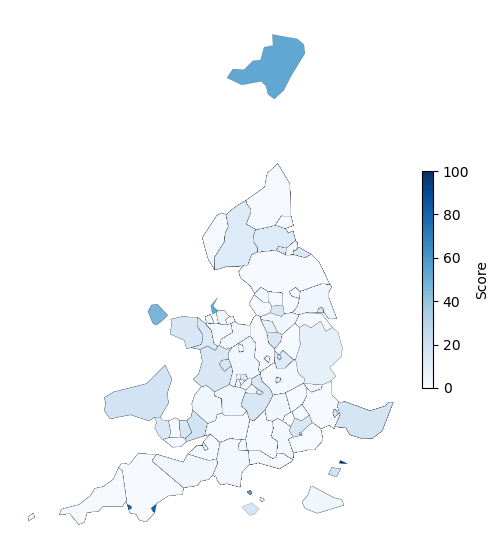

In [1113]:
# Plotting
cmap = 'Blues'
PLOT_MAP.plot(figsize=(7,7), column='Score', cmap=cmap, linewidth=0.1, edgecolor='black')
norm = plt.Normalize(PLOT_MAP['Score'].min(), PLOT_MAP['Score'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, fraction=0.02, pad=0.02)

cbar.set_label('Score')

plt.axis("off")
plt.show()

In [2]:
EPO_IPC = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_IPC.txt',sep='|')
EPO_Patents = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_Inventor_reg.txt',sep='|')
EPO_Citations = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Citation data/202001_EPO_CITATIONS.txt',sep='|')
EPO_Citations['Cited_Appln_id'] = EPO_Citations['Cited_Appln_id'].fillna(0).astype(int) # Setting 0 for nan values

In [13]:
EPO_Patents_PURE = EPO_Patents.loc[EPO_Patents['reg_share'] == 1] # Regional share is 1 so only entirely localised patents
EPO_Patents_PURE_GB = EPO_Patents_PURE.loc[EPO_Patents_PURE['ctry_code'] == 'GB'] # Region is also GB so only from UK
EPO_Patents_CLEAN = EPO_Patents_PURE_GB[['appln_id','reg_code']].drop_duplicates() 

IPC_Patent_MERGE = EPO_Patents_CLEAN.merge(EPO_IPC, left_on='appln_id', right_on='appln_id') # Associating known IPCs to their specific patents

Patent_IDS = IPC_Patent_MERGE['appln_id'].unique() # All patent IDS with known information

Citations_CHECK = EPO_Citations[EPO_Citations['Citing_appln_id'].isin(Patent_IDS)] # Allowing only cititions (Citing) about which we know the patent and IPC information
Citations_READY = Citations_CHECK[Citations_CHECK['Cited_Appln_id'].isin(Patent_IDS)] # Allowing only cititions (Cited) about which we know the patent and IPC information

edge_list = np.array(Citations_READY[['Cited_Appln_id','Citing_appln_id']]) # Edge list with only the known patents

### Modifiable parameters

In [486]:
relationships = 200

#### Allocating data to graph

In [645]:
# Generating graph according to number of selected pairs
edge_list_cut = edge_list[:]
graph = nx.Graph()
graph.add_edges_from(edge_list_cut)

In [646]:
Patent_IPCS_FF = IPC_Patent_MERGE[IPC_Patent_MERGE['appln_id'].isin(list(graph.nodes()))] # Filtering the patent nodes so that we only consider those occuring in the graph
Patent_IPCS_FF['IPC'] = Patent_IPCS_FF['IPC'].astype(str).str[:1] # Reducing the IPC to a single character
Patent_IPCS_FFD = Patent_IPCS_FF.drop(columns='reg_code').drop_duplicates() # Removing regions: No longer considering location
Patent_IPCS_FFD_red = Patent_IPCS_FFD[['appln_id','IPC']] # Patent data ready to be associated to the graph nodes

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_80222/3683382818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Patent_IPCS_FF['IPC'] = Patent_IPCS_FF['IPC'].astype(str).str[:1] # Reducing the IPC to a single character


In [647]:
ID_TABLE = list(Patent_IPCS_FFD['appln_id']) # All IDs to be associated with IPCs

In [648]:
IPC_TABLE = []

for i in tqdm(range(len(Patent_IPCS_FFD))):
    current_IPCs = list(Patent_IPCS_FFD.loc[Patent_IPCS_FFD['appln_id'] == list(Patent_IPCS_FFD['appln_id'])[i]]['IPC'])
    IPC_TABLE.append(list(set(current_IPCs)))

IPC_TABLE = [''.join(sublist) for sublist in list(IPC_TABLE)] # Table of all IPC codes

100%|████████████████████████████████████| 36273/36273 [02:49<00:00, 214.03it/s]


In [649]:
Attributes_IPC = dict(zip(ID_TABLE, IPC_TABLE)) # Table of all IPC codes with associated 
nx.set_node_attributes(graph, 'N', name="IPC") # Set all nodes without an IPC to N
nx.set_node_attributes(graph, Attributes_IPC, name="IPC") # Set all nodes with their IPC

In [650]:
# Setting dates 
Attributes = IPC_Patent_MERGE[['appln_id','prio_year']].astype(int).drop_duplicates().set_index('appln_id').T.to_dict('list')
Attributes = {key: value[0] for key, value in Attributes.items()}
nx.set_node_attributes(graph, Attributes, name="date")

In [651]:
reg_drop = Patent_IPCS_FF.drop_duplicates()
REG_TABLE = []

for i in tqdm(range(len(reg_drop))):
    current_REGs = list(reg_drop.loc[reg_drop['appln_id'] == list(reg_drop['appln_id'])[i]]['reg_code'])
    REG_TABLE.append(list(set(current_REGs)))

100%|████████████████████████████████████| 50971/50971 [05:54<00:00, 143.75it/s]


In [652]:
Attributes_REG = dict(zip(ID_TABLE, REG_TABLE)) # Table of all reg codes with associated 
nx.set_node_attributes(graph, 'N', name="REG") # Set all nodes without a reg to N
nx.set_node_attributes(graph, Attributes_REG, name="REG") # Set all nodes with their reg

In [653]:
GCC = sorted(nx.connected_components(graph), key=len, reverse=True)
GGIANT = graph.subgraph(GCC[0])

In [654]:
print("Giant connected component percentage:",round(len(GGIANT.nodes())/len(graph.nodes())*100,2),"%")

Giant connected component percentage: 3.66 %


In [655]:
# Setting positions 
pos_spring = nx.spring_layout(GGIANT)
pos = {list(GGIANT.nodes())[i]: (list(dict(pos_spring).values())[i][0], list(nx.get_node_attributes(GGIANT, 'date').values())[i], list(dict(pos_spring).values())[i][1]) for i in range(len(GGIANT.nodes))}
nx.set_node_attributes(GGIANT, pos, name="pos")

#### Plotting network in 3D

In [656]:
def network_plot_3D(G, angle, save, IPC_FILTER_SELECTION, NORMALISE_TIME):

    # extracting info
    pos = nx.get_node_attributes(G, 'pos')
    n = G.number_of_nodes()
    dates = list(nx.get_node_attributes(G, 'date').values())
    IPCs = list(nx.get_node_attributes(G, 'IPC').values())

    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(12,12))
        ax = fig.gca(projection='3d')
        
        jcounter = 0
        for key, value in pos.items(): # nodes
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            if NORMALISE_TIME == True:
                relative_output = (10+20*G.degree(key))/(1+1*abs(max(dates)-value[1])) 
            else:
                relative_output = (5+5*G.degree(key))
            
            if IPC_FILTER_SELECTION in IPCs[jcounter]:
                ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = plot_colormap, s=relative_output, edgecolors='k', alpha=0.9) # Out degree since those CITE the most
            else:
                ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = plot_colormap, s=relative_output, edgecolors='k', alpha=0.2)
                
            #ax.text(xi, yi, zi+0.1, s=IPCs[jcounter], c='b', fontsize=7)
            
            jcounter += 1
            
        c_selection = mpl.cm.magma(np.linspace(0,1,int(abs(max(dates)-min(dates)))+1)) # Edge Colors
        
        jcounter = 0
        for i,j in enumerate(G.edges()): # edges
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            
            ax.plot(x, y, z, c=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.2, linewidth=0.5)
                
            #ax.quiver(x[1], y[1], z[1], x[0]-x[1], y[0]-y[1], z[0]-z[1], color=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.5, linewidth=0.5)
            
    # viewpoint
    ax.set_box_aspect([1,2,1])
    ax.view_init(30, angle)
            
    if save is not False:
        file_dir = "/Users/joebacchus/Desktop/3D_plots/"+str(angle)+".png"
        plt.savefig(file_dir, dpi=300)
        plt.close("all")
        print('Done.')
        
    plt.show()
    
    return

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_80222/1257012192.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


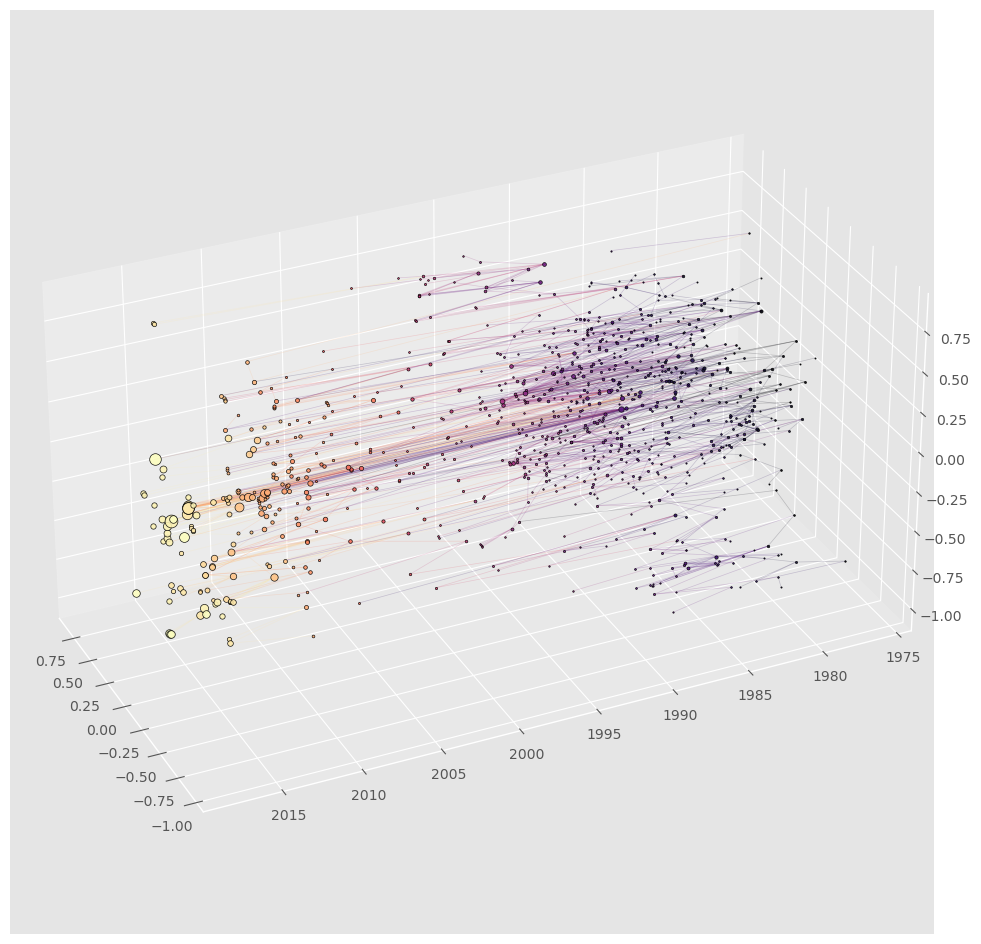

In [657]:
network_plot_3D(GGIANT, 155, False, '', True)

In [ ]:
to_transform_IDIPC = pd.DataFrame({'ID': GGIANT.nodes(), 'IPC':nx.get_node_attributes(GGIANT,'IPC').values()})
to_transform_IDIPC['IPC'] = to_transform_IDIPC['IPC'].apply(lambda x: list(x))
to_transform_IDIPC = to_transform_IDIPC.explode('IPC').reset_index(drop=True)

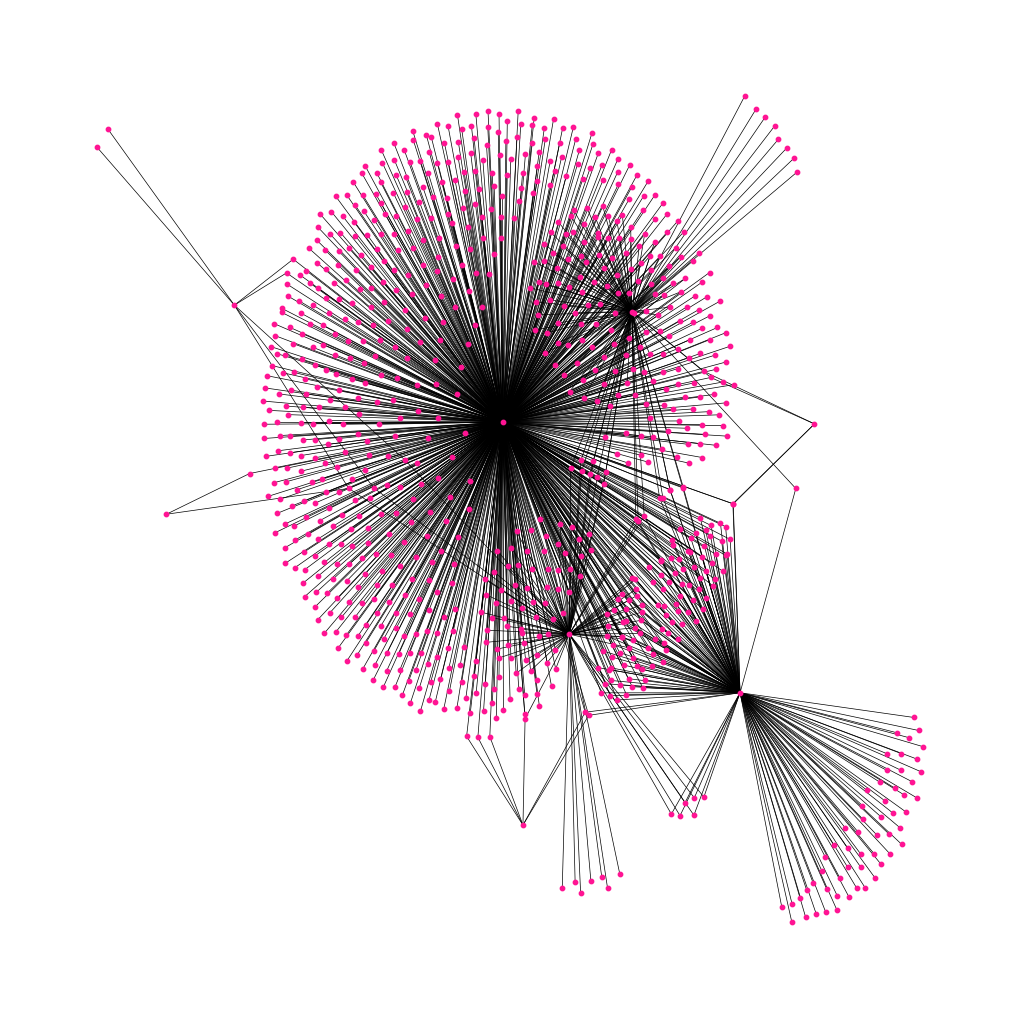

In [644]:
plt.figure(figsize=(10,10))
BPG = nx.Graph()
BPG.add_nodes_from(set(list(to_transform_IDIPC['ID'])),bipartite=0)
BPG.add_nodes_from(set(list(to_transform_IDIPC['IPC'])),bipartite=1)
BPG.add_edges_from(list(zip(list(to_transform_IDIPC['ID']),list(to_transform_IDIPC['IPC']))))

nx.draw(BPG,  
        with_labels = False,
        node_color='deeppink',
        node_size=10,
        width=0.5,
        arrowsize=5,
        font_color="black",
        font_size=10)

In [596]:
pd.DataFrame(dict(nx.get_node_attributes(GGIANT,'IPC')).items(),columns=['ID','IPC'])['IPC'].value_counts()

C       554
DC      109
CA       87
CB       62
A        56
BCA      22
D         8
DCB       8
B         7
DCA       6
BA        6
EC        3
BDCA      3
G         2
ECA       2
GC        2
FCA       2
DCF       2
DA        1
GB        1
GCB       1
GCHB      1
CH        1
ECB       1
Name: IPC, dtype: int64

In [546]:
NUTS_level = 3 # Selected NUTS

shapefile_data = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
space_GB = shapefile_data.loc[shapefile_data['CNTR_CODE'] == "UK"] # Restricting to UK
space_GB_NUTS = space_GB.loc[shapefile_data['LEVL_CODE'] == NUTS_level][['NUTS_ID','geometry']] # Restricting to selected NUTS

In [547]:
shapefile_data

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483..."
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
4,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
...,...,...,...,...,...,...,...,...,...,...
2005,TRC21,3,TR,Şanlıurfa,Şanlıurfa,4.0,2,3,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,3,TR,Diyarbakır,Diyarbakır,4.0,2,3,TRC22,"POLYGON ((6989716.599 2273670.524, 6982786.486..."
2007,NO0B2,3,NO,Svalbard,Svalbard,3.0,3,1,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."
2008,NO0B,2,NO,Jan Mayen and Svalbard,Jan Mayen and Svalbard,NaN,0,0,NO0B,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [ ]:
int_frame_degloc = pd.DataFrame({'Degrees':dict(list(GGIANT.degree())).values(),'ID':GGIANT.nodes()})
shapefile_degree = reg_drop[['appln_id','reg_code']].merge(int_frame_degloc, left_on='appln_id', right_on='ID')[['reg_code','Degrees']]

In [549]:
shapefile_degree_plot = shapefile_degree.merge(space_GB_NUTS, left_on='reg_code', right_on='NUTS_ID')[['Degrees','reg_code','geometry']]
shapefile_degree_plot

,Degrees,reg_code,geometry
0,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
1,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
2,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
3,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
4,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
5,3,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
6,3,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
7,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
8,1,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."
9,2,UKH23,"POLYGON ((3641428.795 3257056.215, 3645219.311..."


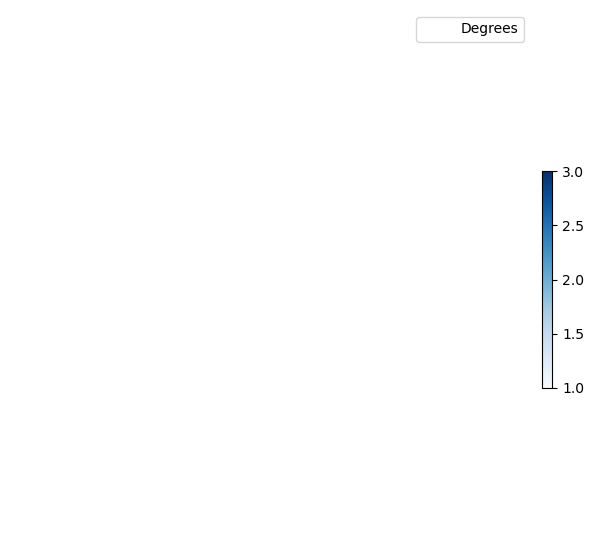

In [550]:
# Plotting
cmap = 'Blues'
shapefile_degree_plot.plot(figsize=(7,7), column='Degrees', cmap=cmap, linewidth=0.1)
norm = plt.Normalize(shapefile_degree_plot['Degrees'].min(), shapefile_degree_plot['Degrees'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, fraction=0.02, pad=0.02)

plt.axis("off")
plt.show()

In [ ]:
ID_TABLE = list(Patent_IPCS_FFD['appln_id']) # All IDs to be associated with IPCs
IPC_TABLE = []

for i in tqdm(range(len(Patent_IPCS_FFD))):
    current_IPCs = list(Patent_IPCS_FFD.loc[Patent_IPCS_FFD['appln_id'] == list(Patent_IPCS_FFD['appln_id'])[i]]['IPC'])
    IPC_TABLE.append(list(set(current_IPCs)))

IPC_TABLE = [''.join(sublist) for sublist in list(IPC_TABLE)] # Table of all IPC codes